# 0. Importing Necessary Packages

In [208]:
%set_env PATH=/root/anaconda3/bin:/root/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/.fzf./bin
# python vscode kernel restart 이후에도 base(python 3.7.6) 정상 작동하는 역할

env: PATH=/root/anaconda3/bin:/root/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/.fzf./bin


In [209]:
# Printing the information of Python, IPython, OS, and the generation date.
%load_ext version_information
%version_information
%matplotlib inline

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


In [210]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'astropy', 'pandas']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.18.1
matplotlib: ver 3.1.3
astropy: ver 4.0
pandas: ver 1.0.1


In [211]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import numpy as np
import glob, os
from matplotlib import pyplot as plt
from astropy.io import fits
import pandas as pd
from acstools import acszpt
from reproject import reproject_interp

# 1. Writing Input Files

## 1) Image list

In [212]:
dir_img = "../1st_TASK_Relics_SMACS/reduced-img/60mas/"
band = ["F105W", "F160W"]
imglist_sub = sorted(glob.glob(dir_img+"*.fits"))
imglist_sub
imglist = [imglist_sub[15], imglist_sub[24]]
imglist
 

['../1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_drz.fits',
 '../1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_drz.fits']

In [213]:
''' 
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
hdu1 = fits.open(get_pkg_data_filename('../img/anal-img/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_drz.fits'))# [0] ''' 
# print(hdu1[0], "\n" , hdu1[1], "\n" , hdu1[2], "\n" , hdu1[3], "\n")
# imglist = [hdu1[1], hdu1[2]] 
# hdu1[0].header

" \nfrom astropy.io import fits\nfrom astropy.utils.data import get_pkg_data_filename\nhdu1 = fits.open(get_pkg_data_filename('../img/anal-img/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_drz.fits'))# [0] "

## 2) Configuration file

In [214]:
config_name = "config.txt"
os.system("sex -dd > "+config_name)

0

## 3) Output parameter file

In [215]:
param_name = "output.param"
f = open(param_name, "w")
f.write("X_IMAGE\n")    # Object position along x [pixel]
f.write("Y_IMAGE\n")    # Object position along y [pixel]
f.write("NUMBER\n")    # Object number
f.write("MAG_AUTO\n")    # Kron-like elliptical aperture magnitude [mag]
f.write("MAGERR_AUTO\n")    # RMS error for MAG_AUTO    [mag]
f.write("MAG_ISO\n") # Isophotal Magnitude
f.write("MAGERR_ISO\n") # Isophotal Magnitude Error
f.write("MAG_ISOCOR\n")
f.write("MAGERR_ISOCOR\n")
f.write("KRON_RADIUS\n")    # Kron apertures in units of A or B
f.write("BACKGROUND\n")    # Background at centroid position
f.write("ALPHA_J2000\n")    # Right ascension of object center (J2000)
f.write("DELTA_J2000\n")    # Declination of object center (J2000)
f.write("A_IMAGE\n")    # Along major axis
f.write("B_IMAGE\n")    # Along minor axis
f.write("THETA_IMAGE\n")    # Position angle
f.write("MU_MAX\n")    # Peak surface brightness above background
f.write("FLAGS\n")    # Extraction flags
f.write("FWHM_IMAGE\n")    # FWHM assuming a gaussian core
f.write("FLUX_RADIUS\n")    # Half-light radii
f.write("CLASS_STAR\n")    # Star/Galaxy classifier output
f.close()

## 4) Determining input parameters

In [216]:
hdr_1 = fits.getheader(imglist[0])
hdr_2 = fits.getheader(imglist[1])

### 4-a) zeropoint calculation from imageheader value

In [217]:
# band = ["F105W", "F160W"]
cat_name = ["{}.cat".format(band[0]), "{}.cat".format(band[1])]
detect_minarea = 9  # DETECT_MINAREA = 5 (default)
detect_thresh = 0.55  #1이었음 # DETECT_THRESH = 1.5 (default)
saturated = 100.0  # SATUR_LEVEL = 100.0 (depending on the image!)
mag0 = [-2.5*np.log10(hdr_1['PHOTFLAM'])-5.0*np.log10(hdr_1['PHOTPLAM'])-2.408,
        -2.5*np.log10(hdr_2['PHOTFLAM'])-5.0*np.log10(hdr_2['PHOTPLAM'])-2.408]
# mag0 = [26.268, 25.946]
egain = [hdr_1['CCDGAIN']*hdr_1['EXPTIME'], hdr_2['CCDGAIN']*hdr_2['EXPTIME']]
# GAIN (effective gain) = gain*exptime (for c/s image) --> this parameter only affects the magnitude error value!
pixel_scale = 0.06  # arcsec/pixel
fwhm = [0.2, 0.2] #이번에 내가 쓰는 reduce img는 0.06arcsec/pixel   # For HST images, seeing FWHMs are typically 3 pixels (~ 0.09 arcsec).
# However, you can directly measure the FWHM value in your image using imexamine or etc.,
# because the FWHM value can also vary with image quality.
back_size = [64, 64]  # BACK_SIZE = 64 (default) --> 32 (revised)
# Smaller BACK_SIZE --> Can subtract more local background --> Can detect more sources
back_filtersize = [3, 3]

checkimg = ["{}_aper.fits".format(band[0]), "{}_aper.fits".format(band[1])]  # CHECKIMAGE_NAME (apertures)
refimg = imglist[0]


deblend_nthresh = [64, 64]
debelnd_mincont = [0.0001, 0.0001]

backphoto_type = "LOCAL"
backphoto_thick = 24

weight_image = ["../1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_rms.fits", "../1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_rms.fits"]
refimg_rmsmap = weight_image[0]
weight_type = "MAP_RMS" #MAP_RMS, MAP_WEIGHT
weight_gain = "Y"

filtering = "Y"
filter_name = "gauss_1.5_3x3.conv"
# filter_thresh = [0.5, 1.0]

### 4-b) PHOTFLAM / PHOTPLAM calculation by ACS zeropoint calculation system

In [218]:
''' 
dates = ['2011-07-16']
queries1 = []
queries2 = []
for date in dates:
    q1 = acszpt.Query(date=date, detector='WFC', filt='F606W')
    zpt_table = q1.fetch()
    # Each object has a zpt_table attribute, so we save the instance
    queries1.append(q1)
for date in dates:
    q2 = acszpt.Query(date=date, detector='WFC', filt='F814W')
    zpt_table = q2.fetch()
    # Each object has a zpt_table attribute, so we save the instance
    queries2.append(q2)


hdr_1["PHOTFLAM"]= q1.zpt_table['PHOTFLAM'][0].value
hdr_1["PHOTPLAM"]= q1.zpt_table['PHOTPLAM'][0].value
hdr_2["PHOTFLAM"]= q2.zpt_table['PHOTFLAM'][0].value
hdr_2["PHOTPLAM"]= q2.zpt_table['PHOTPLAM'][0].value


''' 

' \ndates = [\'2011-07-16\']\nqueries1 = []\nqueries2 = []\nfor date in dates:\n    q1 = acszpt.Query(date=date, detector=\'WFC\', filt=\'F606W\')\n    zpt_table = q1.fetch()\n    # Each object has a zpt_table attribute, so we save the instance\n    queries1.append(q1)\nfor date in dates:\n    q2 = acszpt.Query(date=date, detector=\'WFC\', filt=\'F814W\')\n    zpt_table = q2.fetch()\n    # Each object has a zpt_table attribute, so we save the instance\n    queries2.append(q2)\n\n\nhdr_1["PHOTFLAM"]= q1.zpt_table[\'PHOTFLAM\'][0].value\nhdr_1["PHOTPLAM"]= q1.zpt_table[\'PHOTPLAM\'][0].value\nhdr_2["PHOTFLAM"]= q2.zpt_table[\'PHOTFLAM\'][0].value\nhdr_2["PHOTPLAM"]= q2.zpt_table[\'PHOTPLAM\'][0].value\n\n\n'

## 5) Shell script for SExtractor photometry

In [219]:
scr_name = "sephot.sh"
f = open(scr_name, "w")
for i in np.arange(len(band)):
    
    
    
    # Reference image 
    if (imglist[i] == refimg):
        txt = "sex "+imglist[i]+" -c config.txt -CATALOG_NAME "+cat_name[i]+" -PARAMETERS_NAME output.param "
        txt += f"-WEIGHT_GAIN {weight_gain:s} -WEIGHT_IMAGE {weight_image[i]:s} -WEIGHT_TYPE {weight_type:s} "

    # Non-reference image
    else:
        txt = "sex "+refimg+","+imglist[i]+" -c config.txt -CATALOG_NAME "+cat_name[i]+" -PARAMETERS_NAME output.param "
        txt += f"-WEIGHT_GAIN {weight_gain:s} -WEIGHT_IMAGE {refimg_rmsmap:s},{weight_image[i]:s} -WEIGHT_TYPE {weight_type:s} "

    #==== new added param
    txt += f"-BACK_FILTERSIZE {back_filtersize[i]:d} -DEBLEND_NTHRESH {deblend_nthresh[i]:d} -DEBLEND_MINCONT {debelnd_mincont[i]:.5f} -BACKPHOTO_TYPE {backphoto_type:s} -BACKPHOTO_THICK {backphoto_thick:d} "
    txt += f"-FILTER {filtering:s} -FILTER_NAME {filter_name:s} " #filtering part 제대로 적용안되는 듯 하면서 여전히 -FILTER_THRESH {filter_thresh[0]:.4f},{filter_thresh[1]:.4f} "
    #==== origin param
    txt += f"-DETECT_MINAREA {detect_minarea:d} -DETECT_THRESH {detect_thresh:.1f} "
    txt += f"-FILTER_NAME /usr/share/sextractor/default.conv -SATUR_LEVEL {saturated:.1f} "
    txt += f"-MAG_ZEROPOINT {mag0[i]:.4f} -GAIN {egain[i]:.2f} -PIXEL_SCALE {pixel_scale:.2f} "
    txt += f"-SEEING_FWHM {fwhm[i]:.2f} -STARNNW_NAME /usr/share/sextractor/default.nnw -BACK_SIZE {back_size[i]:d} "
    txt += "-CHECKIMAGE_TYPE APERTURES -CHECKIMAGE_NAME "+checkimg[i] # -CHECKIMAGE_TYPE APERTURES 
    txt += "\n"
    
    f.write(txt)
    
    
f.close()

# 2. Running SExtractor

In [220]:
os.system("sh sephot.sh")
# Run this and see the terminal where the Jupyter Notebook is open!

0

In [221]:
# !sex ../1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_drz.fits -c config.txt -CATALOG_NAME F160W.cat -PARAMETERS_NAME output.param -WEIGHT_GAIN Y -WEIGHT_IMAGE ../1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_rms.fits -WEIGHT_TYPE MAP_RMS -BACK_FILTERSIZE 3 -DEBLEND_NTHRESH 64 -DEBLEND_MINCONT 0.00010 -BACKPHOTO_TYPE LOCAL -BACKPHOTO_THICK 24 -FILTER Y -FILTER_NAME gauss*.conv -DETECT_MINAREA 9 -DETECT_THRESH 1.0 -FILTER_NAME /usr/share/sextractor/default.conv -SATUR_LEVEL 100.0 -MAG_ZEROPOINT 25.9462 -GAIN 5154.37 -PIXEL_SCALE 0.06 -SEEING_FWHM 0.20 -STARNNW_NAME /usr/share/sextractor/default.nnw -BACK_SIZE 64 -CHECKIMAGE_TYPE APERTURES -CHECKIMAGE_NAME F160W_aper.fits
# !sex ../1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_drz.fits,../1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_drz.fits -c config.txt -CATALOG_NAME F105W.cat -PARAMETERS_NAME output.param -WEIGHT_GAIN Y -WEIGHT_IMAGE ../1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f160w_v1_rms.fits,../1st_TASK_Relics_SMACS/reduced-img/60mas/hlsp_relics_hst_wfc3ir-60mas_smacs0723-73_f105w_v1_rms.fits -WEIGHT_TYPE MAP_RMS -BACK_FILTERSIZE 3 -DEBLEND_NTHRESH 64 -DEBLEND_MINCONT 0.00010 -BACKPHOTO_TYPE LOCAL -BACKPHOTO_THICK 24 -FILTER Y -FILTER_NAME gauss*.conv -DETECT_MINAREA 9 -DETECT_THRESH 1.0 -FILTER_NAME /usr/share/sextractor/default.conv -SATUR_LEVEL 100.0 -MAG_ZEROPOINT 26.2688 -GAIN 3779.35 -PIXEL_SCALE 0.06 -SEEING_FWHM 0.20 -STARNNW_NAME /usr/share/sextractor/default.nnw -BACK_SIZE 64 -CHECKIMAGE_TYPE APERTURES -CHECKIMAGE_NAME F105W_aper.fits


# 3. Reading the Data

In [222]:
# exec("dat_{} = np.genfromtxt(cat_name[0], dtype=None, encoding='ascii', names=colnames)".format(band[0]))
# exec("dat_{} = np.genfromtxt(cat_nam"e[1], dtype=None, encoding='ascii', names=colnames)".format(band[1]))
# Code that makes data name containts wave band
colnames = ['x','y','num','mag_auto','magerr_auto','mag_iso','magerr_iso','mag_isocor','magerr_isocor','kron','backgr','ra','dec', 
            'a','b','theta','mu0','flag','fwhm','flxrad','cl']
dat_0 = np.genfromtxt(cat_name[0], dtype=None, encoding='ascii', names=colnames)
dat_1 = np.genfromtxt(cat_name[1], dtype=None, encoding='ascii', names=colnames)

In [223]:
pd.DataFrame(dat_0).head(5)

,x,y,num,mag_auto,magerr_auto,mag_iso,magerr_iso,mag_isocor,magerr_isocor,kron,...,ra,dec,a,b,theta,mu0,flag,fwhm,flxrad,cl
0,2279.9648,1100.4969,1,17.5936,0.0096,17.5547,0.0070,17.5514,0.0070,3.50,...,110.846385,-73.477527,5.236,4.891,-38.93,14.4550,6,15.20,2.874,0.973
1,2229.3779,1142.1075,2,18.9493,0.0052,18.8972,0.0052,18.8914,0.0051,3.50,...,110.849349,-73.476834,4.190,4.084,-81.23,16.0780,2,5.14,2.411,0.977
2,2641.2532,1449.2960,3,20.4501,0.0056,20.4396,0.0055,20.3876,0.0054,3.52,...,110.825215,-73.471714,10.044,8.545,-68.92,19.0310,2,5.08,8.604,0.029
3,2282.3169,1111.5690,4,22.5514,0.0318,22.8898,0.0337,22.8832,0.0335,3.55,...,110.846247,-73.477343,2.162,1.085,86.70,19.7265,3,7.82,2.074,0.997
4,2277.4409,1131.0980,5,24.5617,3.9055,25.7114,0.1899,24.8477,0.1329,8.04,...,110.846533,-73.477017,2.090,1.544,-78.57,23.2512,1,7.90,5.020,0.801


In [224]:
pd.DataFrame(dat_1).head(5)

,x,y,num,mag_auto,magerr_auto,mag_iso,magerr_iso,mag_isocor,magerr_isocor,kron,...,ra,dec,a,b,theta,mu0,flag,fwhm,flxrad,cl
0,2279.9648,1100.4969,1,17.1116,0.0061,16.8147,inf,16.8125,inf,3.50,...,110.846385,-73.477527,5.236,4.891,-38.93,13.7810,7,30.37,2.575,0.981
1,2229.3779,1142.1075,2,18.9285,0.0452,18.8767,inf,18.8687,inf,3.50,...,110.849349,-73.476834,4.190,4.084,-81.23,15.9878,2,3.85,2.751,0.981
2,2641.2532,1449.2960,3,19.9185,0.0035,19.9420,0.0035,19.9003,0.0035,3.52,...,110.825215,-73.471714,10.044,8.545,-68.92,18.5495,2,5.53,8.439,0.029
3,2282.3169,1111.5690,4,22.9239,0.0310,23.2942,inf,23.2799,inf,3.55,...,110.846247,-73.477343,2.162,1.085,86.70,20.1349,3,9.17,2.481,1.000
4,2277.4409,1131.0980,5,23.3313,0.6779,25.6938,0.1554,23.1896,0.0370,8.04,...,110.846533,-73.477017,2.090,1.544,-78.57,22.9365,1,10.76,7.978,0.638


# 4. Galactic Extinction in Magnitude
## Magnitude Correction

In [225]:
A_lambda_f105w = 1.015
A_lambda_f160w = 0.470 
EBV = 0.1893
Extmag_f105w = A_lambda_f105w * EBV
Extmag_f160w = A_lambda_f160w * EBV
dat_0['mag_isocor'] = dat_0['mag_isocor'] - Extmag_f105w #dat_0 : f105w
dat_1['mag_isocor'] = dat_1['mag_isocor'] - Extmag_f160w #dat_1 : f160w

# 5. Plotting the Figures

In [226]:
%matplotlib inline

### 0) RA/DEC

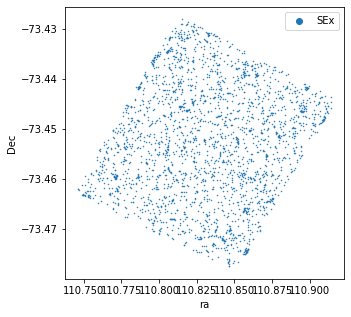

In [227]:
fig, axs = plt.subplots(1, 1, figsize=(5,5))
axs.plot(dat_0['ra'], dat_0['dec'], 'o', ms=0.5, label = 'SEx')
axs.set_xlabel("ra")
axs.set_ylabel("Dec")
# change legend markersize
lgnd = axs.legend()
lgnd.legendHandles[0]._legmarker.set_markersize(6)


### 1) Mag-MagErr Plot

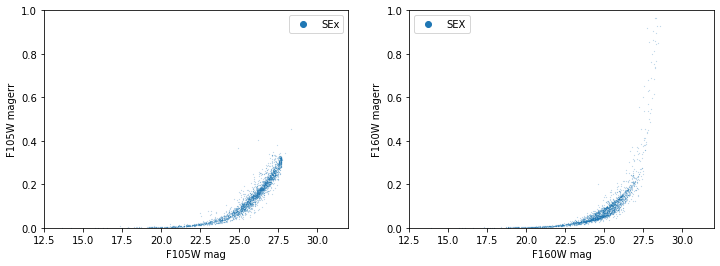

In [228]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
mag_range = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0)
# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(dat_0['mag_isocor'][mag_range], dat_0['magerr_isocor'][mag_range], 'o', ms=0.1, label='SEx')
ax[0].set_xlim([12.5, 32])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('F105W mag')
ax[0].set_ylabel('F105W magerr')


ax[1].plot(dat_1['mag_isocor'][mag_range], dat_1['magerr_isocor'][mag_range], 'o', ms=0.1, label='SEX')
ax[1].set_xlim([12.5, 32])
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('F160W mag')
ax[1].set_ylabel('F160W magerr')

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)

### 2) Magnitude - stellarity (``CLASS_STAR``) digram

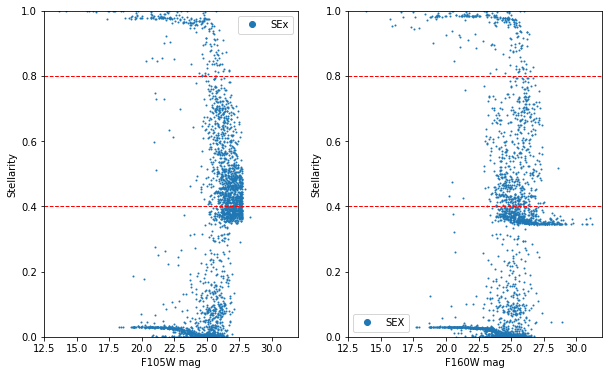

In [229]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
mag_range = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0)
# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax[0].plot(dat_0['mag_isocor'][mag_range], dat_0['cl'][mag_range], 'o', ms=1, label='SEx')
ax[0].set_xlim([12.5, 32])
ax[0].set_ylim([0.0, 1.0])
ax[0].set_xlabel('F105W mag')
ax[0].set_ylabel('Stellarity')
ax[0].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[0].axhline(0.8, 0, 1, color='red', ls='--', lw=1)


ax[1].plot(dat_1['mag_isocor'][mag_range], dat_1['cl'][mag_range], 'o', ms=1, label='SEX')
ax[1].set_xlim([12.5, 32])
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('F160W mag')
ax[1].set_ylabel('Stellarity')
ax[1].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[1].axhline(0.8, 0, 1, color='red', ls='--', lw=1)

#=================================================================
lgnd0 = ax[0].legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
lgnd1 = ax[1].legend()
lgnd1.legendHandles[0]._legmarker.set_markersize(6)

### 3) CMDs of galaxies

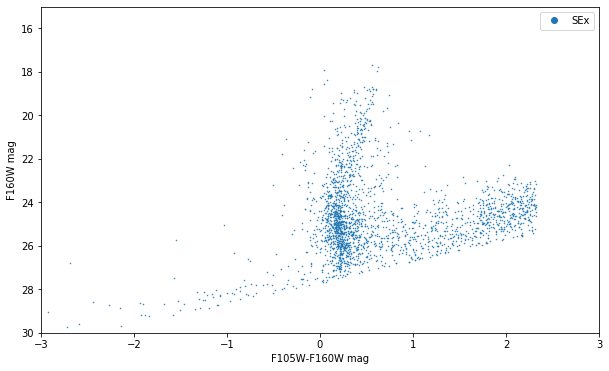

In [230]:
# gal_cnd = ((dat_V['mag_isocor'] < 30.0) & (dat_V['magerr_isocor'] < 1) & (dat_I['mag_isocor'] < 30.0) & (dat_I['magerr_isocor'] < 1) & \
#           (dat_V['flxrad'] > 4.) & (dat_V['fwhm'] > 4.) & (dat_I['flxrad'] > 4.) & (dat_I['fwhm'] > 4.) & \
#           (dat_V['mag_isocor']-dat_I['mag_isocor'] > -5.0) & (dat_V['mag_isocor']-dat_I['mag_isocor'] < 5.0) & \
#           (dat_I['cl'] < 0.4)) 

fig, ax = plt.subplots(1, 1, figsize=(10,6))
galcnd = (dat_0['mag_isocor'] < 99.0)&(dat_1['mag_isocor']<99.0)&(dat_0['flag']<4) #&(dat_0['flxrad'] > 4.) & (dat_0['fwhm'] > 4.) & (dat_1['fwhm'] > 4.) & (dat_1['merr'] < 0.5) & (dat_0['merr'] < 0.5)&(dat_1['cl'] < 0.4)


# magnitude of 99.0 means the source not detected in the 606-band image but detected in the 814-band image.
ax.plot(dat_0['mag_isocor'][galcnd]-dat_1['mag_isocor'][galcnd], dat_1['mag_isocor'][galcnd], 'o', ms=0.5, label='SEx')
ax.set_xlim([-3, 3])
ax.set_ylim([30, 15])
ax.set_xlabel('F105W-F160W mag')
ax.set_ylabel('F160W mag')

#=================================================================
lgnd0 = ax.legend()
lgnd0.legendHandles[0]._legmarker.set_markersize(6)
